# T6 - Programs

We have seen in previous tutorials how the flow rates between compartments are specified using _parameters_. Thus far, we have considered parameter values being specified in two ways

- Directly specified via the databook
- Computed as a function of other parameters

However, a key function of Atomica is to model the impact of interventions. These interventions are typically framed in the following way:

- The intervention has a unit cost associated with it (e.g. a treatment that costs \$100/person)
- A specified amount of money is made available for the intervention (e.g. \$1000/year)
- The intervention defines a parameter value (matching a parameter in the Framework) for people reached by the intervention. For example, the natural recovery rate for a rate for individuals on treatment may be 20\%, but if someone is on treatment, they have a 90\% chance of recovery

At a high level, the calculation we wish to implement is as follows. Suppose we have an SIR model and there are 100 people infected and diagnosed at the start of the year. The \$1000 of available funding means that 10 people can be treated that year. Of those 10 people, 90\% of them recover, leading to 9 people moving to the 'Recovered' state. For the remaining 90 people, 20\% of them recover, leading to 18 natural recoveries. So that year, a total of 27 people will move from 'Infected' to 'Recovered'. 

In the calculation above, the natural recovery rate of 20\% is readily entered in the databook. However, we wish to parametrize the effect of the intervention in terms of spending, unit cost, and the impact of the intervention for those it reaches. Although it would be possible to implement the calculation via parameter functions, it quickly becomes cumbersome if there are multiple interventions affecting the same model parameter. Therefore, we introduce a second pathway for calculating parameter values, using **'Programs'**. A schematic overview of how programs relate to model parameter values is shown below: 

![t6-parameter-overview](assets/T6/t6_parameter_overwrite.png)

The role of programs is to generate parameter values as a function of spending and coverage. These parameter values then replace the parameter values from the databook during a simulation.

Parameter values from the _databook_ are stored in a _ParameterSet_ which is used to produce results for any given databook and calibration. Similarly, program-specific inputs are read in from the _program book_ which maps to a _ProgramSet_. A ProgramSet together with a set of _program instructions_ is used to generate results incorporating the effect of programs. A schematic overview of how these inputs relate to results is shown below:

![t6-model-structure](assets/T6/t6_model_structure.png)

We will now implement the SIR model with a treatment program described above, to see how these different components are instantiated and used within Atomica. First, we will load in a framework and databook for a simple SIR model:

In [1]:
import atomica as at
import matplotlib.pyplot as plt
P = at.Project(framework='assets/T6/t6_framework_1.xlsx',databook='assets/T6/t6_databook_1.xlsx', do_run=False)
P.settings.update_time_vector(dt=1)

This framework is much the same as the SIR framework in previous tutorials, except that on the parameters sheet, an additional column called 'Targetable' is present. This column specifies whether certain parameters should appear in program books. Since we know that the treatment program is going to change the value of the disease recovery rate, this parameter has a 'y' in the 'Targetable' column:

![t6-framework-targetable](assets/T6/t6_framework_targetable.png)

Elapsed time for running "default": 0.0115s


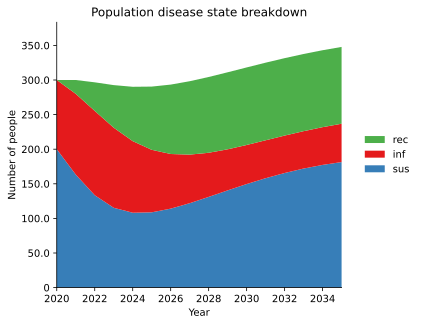

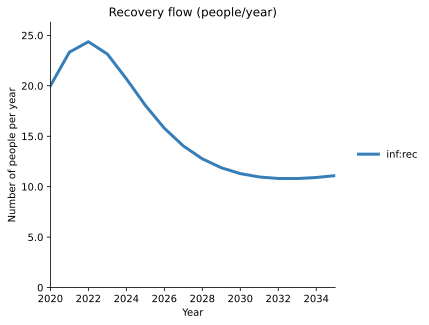

In [2]:
res = P.run_sim(P.parsets[0]);
d = at.PlotData(res,['sus','inf','rec'])
at.plot_series(d,plot_type='stacked');
plt.title('Population disease state breakdown');

d = at.PlotData(res,'inf:rec')
at.plot_series(d);
plt.title('Recovery flow (people/year)');

We will now produce a 'Program book' (sometimes referred to as a 'Progbook') to define our treatment program. The key attributes that we need to capture for the program are

- _Who_ is eligible to receive the program - this is referred to as the program targeting
- _How much_ the program costs per person
- _What_ is the effect of the program on parameter values

The example earlier in this tutorial corresponds to the following

- Everyone who is infected is eligible for the program
- The program costs $100/person
- Individuals that are treated have a 90\% recovery rate

Within each of these three main areas are various additional options for more sophisticated programs - for example, programs targeted only at particular sub-populations, programs that can only be scaled up to a finite limit, and programs interacting with other programs. These are discussed in more detail in the full program documentation [here](http://atomica.tools/docs/master/general/programs/Programs.html).

Notice that program targeting needs to specify which disease states are targeted (e.g. 'Infected') and which populations are targeted (e.g. 'Adults'). These are defined in the framework and databook, respectively. Therefore, while the databook depends only on the framework, the program book depends on both the framework and the databook. This is reflected in the command to create a new program set, which takes in both a framework and a databook:

In [3]:
progset = at.ProgramSet.new(framework=P.framework, data=P.data, tvec=[2020], progs=1)

In the same way that databook and a `ProjectData` object are interchangable and can be thought of as different representations of the same data, the same is true for a program book and a `ProgramSet`. Therefore, the command above is used to produce a new `ProgramSet` which can then be written to a file using the `save` method: 

In [4]:
progset.save('temp.xlsx');

Object saved to /home/vsts/work/1/s/docs/tutorial/temp.xlsx.


Alternatively, a program book can be created for a given project by using the project's `make_progbook` method, which will automatically pass in the project's framework and data.

In [5]:
P.make_progbook('temp.xlsx',progs=1,data_start=2020,data_end=2021);

Object saved to /home/vsts/work/1/s/docs/tutorial/temp.xlsx.


The program book contains three sheets, corresponding to the three key attributes being captured. On the 'Program targeting' sheet, the populations and compartments reached by the program are entered. For the treatment program here, we select only the 'Infected' compartment. We also need to enter 'Y' for the 'Adults' population.

![t6-sheet-targeting](assets/T6/t6_sheet_targeting.png)

<div class="alert alert-block alert-info">
Note that this is essentially specifying the coverage denominator for the program - the denominator at any point in time is the sum of the number of people in all selected compartments within all selected populations
</div>

This sheet should also be used to set the name of the programs. To add and remove programs, it is easiest to use the corresponding methods of the 'ProgramSet' object, rather than manually editing the program book.

On the spending data sheet, we enter the unit cost of the program, and also spending on the program. 

![t6-sheet-spending](assets/T6/t6_sheet_spending.png)

Analogous to the databook, the program book should contain actual data values or future projections not dependent on the model. Typically, this would mean that

- The spending values would only correspond to past years, reflecting actual investment in the program
- The unit cost could contain future values if there are expected to be changes in the cost of the program e.g. if drug prices are expected to drop in the future

The capacity constraint and saturation constraint are discussed in detail in the full 'programs' documentation. However, to a good approximation, the _coverage_ of a program during a timestep is given by dividing the number of people the program has funding for (the annual spending rate divided by the unit cost) by the number of people currently in targeted compartments. For example, if the simulation step size was `0.25` years, then 

- \$250 would be spent between 2020 and 2020.25
- \$250 /(\$100/person)=2.5 people would be covered between 2020 and 2020.25
- If there were 100 people infected, the _coverage_ would be 0.025

Therefore, outside of coverage scenarios (discussed in Tutorial 7), the number of people and fraction covered is an _output_ resulting from spending input and the compartment sizes during a simulation. 

<div class="alert alert-block alert-danger">
The 'coverage' row on the 'Spending data' sheet is for entering real-world reference coverage values only. This allows the computed coverage in the model to be readily compared to existing data. The values entered on this row do not affect the simulation in any way.
</div>

Finally, the impact of the program is entered on the 'Program effects' sheet:

![t6-sheet-effects](assets/T6/t6_sheet_effects.png)

This sheet consists of a set of sub-tables. Each sub-table corresponds to a parameter in the model - any parameter marked as 'Targetable' in the framework will appear on this sheet. There are input cells provided for the baseline value for the parameter in the absence of any programs. Then there are columns for each program specifying the parameter value that applies to individuals covered by the program (or equivalently, the parameter value that would apply if the program coverage was `1.0` for that program, and `0` for all other programs). If nobody receives the treatment intervention, then the parameter value that should apply is the natural recovery rate. Therefore, we enter a value of 0.2 in the 'baseline' column. Then, the treatment program is defined to have a 90\% treatment success rate so we enter 0.9 as the program effect. 

<div class="alert alert-block alert-info">
For single programs in isolation, the final parameter value is equal to the baseline value, plus the coverage multiplied by the program's effect value. If there are multiple programs, the results are qualitatively similar, but see the full program documentation for details on how to capture interactions between programs. 
</div>

We are now almost able to run a simulation with programs. We can start by loading in the program book, which creates a program set

In [6]:
pset = at.ProgramSet.from_spreadsheet('assets/T6/t6_progbook_1.xlsx', framework=P.framework, data=P.data)

The `load_progbook` Project method can be used to load a program book using the project's framework and data, and then store it within the project. 

In [7]:
pset = P.load_progbook('assets/T6/t6_progbook_1.xlsx')

As discussed above, the workflow for programs is that the program set supplies parameter values that replace the values specified in the databook. To facilitate calibration, the databook is typically used for historical values, and then the programs system is used starting from the current year, for all future projections. So the final missing piece of information is the year at which this overwriting should begin, referred to as the 'program start year'. This is specified in a `ProgramInstructions` object (which we will examine in more detail in Tutorials 7 and 8). 

In [8]:
instructions = at.ProgramInstructions(start_year=2020)

We can now run a simulation using programs. For a simulation without programs, we need only specify the parameter set to use. For a simulation with programs, we need to specify a parameter set, a program set, and a set of program instructions. This exactly matches the schematic at the start of this tutorial illustrating the inputs for results with and without programs.

In [9]:
res_baseline = P.run_sim(P.parsets[0],result_name='Baseline')
res_programs = P.run_sim(P.parsets[0],progset=P.progsets[0],progset_instructions=instructions,result_name='Programs')

Elapsed time for running "default": 0.0114s


Elapsed time for running "default": 0.0114s


We can now plot the recovery rate parameter and the resulting number of people flowing into the 'recovered' state each year.

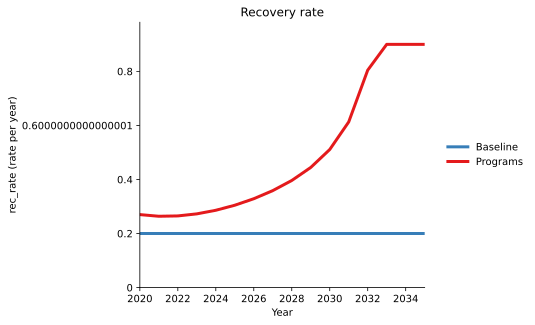

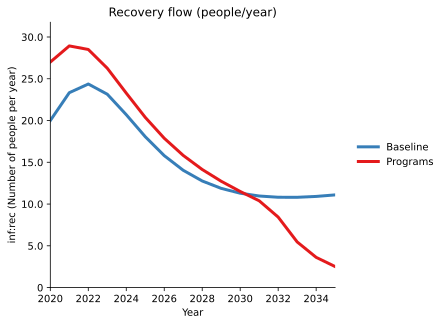

In [10]:
d = at.PlotData([res_baseline, res_programs],'rec_rate')
at.plot_series(d,axis='results');
plt.title('Recovery rate');

d = at.PlotData([res_baseline, res_programs],'inf:rec')
at.plot_series(d,axis='results');
plt.title('Recovery flow (people/year)');

As expected, the recovery rate with the addition of the treatment program is considerably higher than the baseline simulation. However, the flow of people from infected to recovered is initially high, but then drops below the baseline results after around 2022. The program is set up to transfer a fixed number of people per year. If the epidemic is decreasing, then each year fewer and fewer people are infected. Thus the fixed number of people per year is a larger and larger proportion of the total number infected (resulting in the recovery rate increasing over time) and the number of people recovering each year decrease (resulting in a decreasing recovery flow over time). We can verify this by examining the overall proportion of the population infected under the baseline results and with the addition of the treatment program:

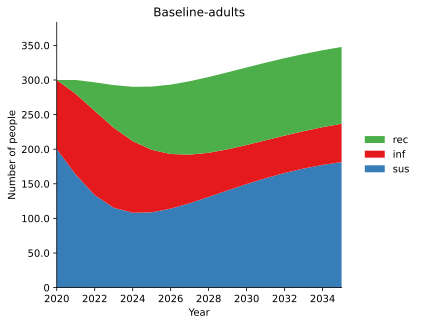

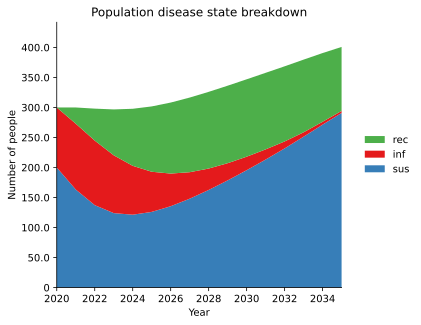

In [11]:
d = at.PlotData([res_baseline, res_programs],['sus','inf','rec'])
at.plot_series(d,plot_type='stacked',axis='outputs');
plt.title('Population disease state breakdown');

This confirms that the treatment program results in a considerable decrease in prevalance. 

## Reconciliation

As discussed above, a simulation that uses program switches from 'ParameterSet' parameters to 'ProgramSet' parameters at the program start year. What happens if the parameter values from programs don't align with values from the parameter set? In some cases, this doesn't matter - for example, if the program set only contains new programs. More commonly though, a project may be set up for a disease such as TB where there were previously programs running in the country. The calibrated parameter set therefore reflects programs running in the country even if the program set is not yet being used. In that case, it is important that the program set values for current spending should produce parameters that match (or are close to) the calibrated values. 

_Reconciliation_ then refers to the process of calibrating the program set to match the program parameters to the parameter set in the program start year.

For example, suppose that the disease natural recovery rate was zero. The databook specifies that the recovery rate is `0.2`. If there is no natural recovery, then we would interpret this value as representing the existing treatment program. The absence of natural recovery means that the program's baseline value should be 0. Thus we would expect that the program's budget in 2020 together with the unit cost should yield a recovery rate of `0.2`. `t6_progbook_2.xlsx` has a baseline of 0 to match this scenario. 

Elapsed time for running "default": 0.0111s


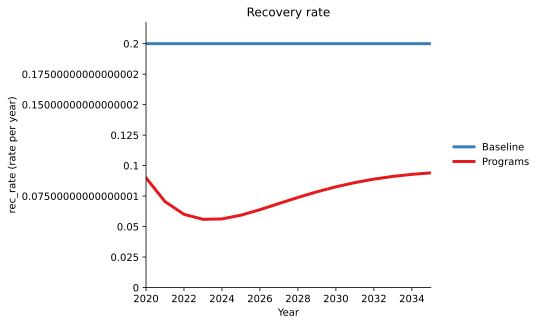

In [12]:
pset = P.load_progbook('assets/T6/t6_progbook_2.xlsx')
res_programs_1 = P.run_sim(P.parsets[0],progset=pset,progset_instructions=instructions,result_name='Programs')
d = at.PlotData([res_baseline, res_programs_1],'rec_rate')
at.plot_series(d,axis='results');
plt.title('Recovery rate');

As shown above, the program produces a recovery rate that is too low. The reason for this is depends on likely sources of error in the data. For example, the recovery rate could be too low because

- There are more infected people than there were in reality - this situation should be resolved during the calibration step
- The actual amount of spending was higher than what was entered in the databook
- The program's unit cost was actually lower
- The treatment program has an associated recovery rate that is actually higher than 0.9
- There were other sources of treatment that _were_ included in the recovery rate parameter but do not correspond to this program. This situation can be avoided by setting the baseline value to include any programs not being explicitly modelled

Reconciliation could in principle involve changing any of these quantities. In practice, typically it is the unit cost and spending that are adjusted, as these often have the highest uncertainty in real data sets. 

Reconciliation can be performed manually, or it can be done automatically using the `reconcile` function. This function takes in arguments to specify whether the spending, unit cost, or program effects can be changed. For example, we can automatically adjust the unit cost as follows:

In [13]:
reconciled_pset = at.reconcile(project=P, parset='default', progset=pset,reconciliation_year=2020, unit_cost_bounds=2.0)[0]

WARNING {reconciliation.py:243} - Reconcilation when parameter is in number units not fully tested


Program set 'default' will be ignored while running project 'default' due to the absence of program set instructions


Elapsed time for running "default": 0.00993s


Reconciling in 2020.00, evaluating from 2020.00 up to 2021.00


ASD: Launching with random seed None
    step=1 choice=0, par=0, pm=0.0, origval=100.0, newval=110.0
     step 1 (0.0 s) -- (orig:0.01210 | best:0.01210 | new:0.01397 | diff:0.001867)
    step=2 choice=1, par=0, pm=1.0, origval=100.0, newval=90.0
     step 2 (0.0 s) ++ (orig:0.01210 | best:0.01210 | new:0.01000 | diff:-0.002100)
    step=3 choice=1, par=0, pm=1.0, origval=90.0, newval=70.0
     step 3 (0.0 s) ++ (orig:0.01210 | best:0.01000 | new:0.005102 | diff:-0.004898)
    step=4 choice=1, par=0, pm=1.0, origval=70.0, newval=30.0
     step 4 (0.0 s) -- (orig:0.01210 | best:0.005102 | new:0.01000 | diff:0.004898)
    step=5 choice=1, par=0, pm=1.0, origval=70.0, newval=50.0
     step 5 (0.0 s) ++ (orig:0.01210 | best:0.005102 | new:0.0004000 | diff:-0.004702)
    step=6 choice=1, par=0, pm=1.0, origval=50.0, newval=10.0
     step 6 (0.0 s) -- (orig:0.01210 | best:0.0004000 | new:0.4900 | diff:0.4896)
    step=7 choice=1, par=0, pm=1.0, origval=50.0, newval=30.0
     step 7 (0.0 s) -

Regardless of how reconciliation is performed, the idea is that the result of reconciliation is a _reconciled progset_ that provides a better match to a given parameter set in the program start year. We expected based on the un-reconciled result that reconciliation based on unit cost should result in decreasing the unit cost to achieve an increase in recovery rate. We can look at the reconciled unit cost to confirm this is what the automatic reconciliation has done:

In [14]:
unit_cost = pset.programs[0].unit_cost.interpolate(2020)[0]
reconciled_cost = reconciled_pset.programs[0].unit_cost.interpolate(2020)[0]
print(f'Original unit cost = ${unit_cost}, reconciled unit cost = ${reconciled_cost}')

Original unit cost = $100.0, reconciled unit cost = $45.0


We can then plot the recovery rate to confirm that the resulting recovery rate matches the parameter set. It's a good idea to verify the quality of the reconciliation because there is no guarantee that the reconciliation was able to actually match the parameter value given the reconciliation constraints. For example, the reconciled unit cost was less than half of the original unit cost, but if the automatic reconciliation was configured to change the unit cost by say, 5% at most, then it would not be possible to reach the target recovery rate.

Elapsed time for running "default": 0.0111s


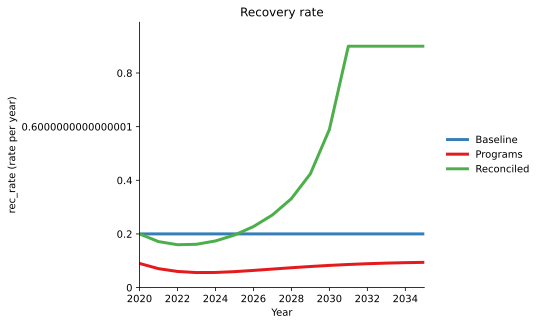

In [15]:
res_programs_2 = P.run_sim(P.parsets[0],progset=reconciled_pset,progset_instructions=instructions,result_name='Reconciled')
d = at.PlotData([res_baseline, res_programs_1, res_programs_2],'rec_rate')
at.plot_series(d,axis='results');
plt.title('Recovery rate');

In this case, we can see that the reconciliation was indeed successful at matching the recovery rate in the parameter set.

<div class="alert alert-block alert-danger">
Reconciliation involves matching the programs to the parameter set <b>in the reconciliation year only</b>. In general, the parameter set and the program set make different assumptions about future parameter values. In this example, the parameter set assumes the recovery rate will remain constant, while the program set assumes the number of people treated each year will remain constant. Therefore it is NOT expected that the parameter set and program set would produce similar values in the future projections.
    
When performing reconciliation, it is important to focus on the reconciliation year only. The reconciliation above was successful because the parameter values match in 2020, even though they differ considerably in say, 2030. 
</div>


## Common intervention types

Atomica does not contain any pre-defined program types. That is, a program is defined by the compartments it targets and the parameters it overwrites, which is solely a function of the framework and the progbook. This means that it is possible to define a wide variety of programs, but on the other hand, it is not possible to simply 'make a vaccine program' - since a vaccine program is defined by having vaccine states in the framework that are affected by the parameters overwritten in the program book. There are examples of how to set up different kinds of programs in the Atomica framework library, but here are some design patterns for common program types.  

### Vaccines

- Framework contains a vaccine compartment, and a targetable vaccination rate parameter
- The program targets the susceptible compartment and overwrites the vaccination rate parameter
- For infant and child vaccination programs, the program only targets the appropriate populations (e.g. only targets a `0-4` population

### Diagnosis screening program

- A screening program is characterised by having a low yield, because many of the people screened do not have the condition being tested.
- The framework contains states for susceptible, undiagnosed, and diagnosed. The latter two states would both be considered infected. A diagnosis parameter moves people from undiagnosed to diagnosed
- The program targets both susceptible and undiagnosed, and overwrites the diagnosis parameter. The program's coverage denominator is increased by including the susceptible compartment, which reduces the impact of the program by decreasing the fraction of undiagnosed people covered.

### Diagnosis

- The framework contains states for susceptible, undiagnosed, and diagnosed. The latter two states would both be considered infected. A diagnosis parameter moves people from undiagnosed to diagnosed
- The program targets only undiagnosed people, and overwrites the diagnosis parameter
- The sensitivity of the diagnosis test corresponds to the program's effect (i.e. a test with low sensitivity would return a negative result for someone that is true positive, so a program effect less than 1 would mean that an affected individual that gets reached by the diagnosis program does not actually become diagnosed). 

### Screening with confirmatory test

- The framework contains states for susceptible, undiagnosed, screened, and diagnosed. Typically the framework would also contain a treatment compartment, where people had to be diagnosed before being treated.
- The progbook would define two programs - a screening program, and a diagnosis program
- Each of those two programs would be set up as described above. The screening program would target susceptible and undiagnosed, and people into the screened compartment. The diagnosis program would target the screened compartment and move people into the diagnosed compartment

### One-off treatment

With an explicit treatment state:

- The framework contains compartments for being diagnosed (or otherwise eligible for treatment) and on treatment
- The treatment program moves people into the treatment state
- The treatment program could also overwrite a treatment success parameter that moves people from being on treatment to being recovered. 

Without an explicit treatment state:

- The framework contains compartments for being diagnosed, and for a successfully treated outcome
- The treatment program moves people from being diagnosed to being successfully treated (e.g. recovered)
- The treatment program's effect is the treatment efficacy

### Sustained treatment

Some treatment programs involve being continuously on treatment without ever changing compartments - for example, ART for HIV treatment. These programs typically have a cost per year of treatment associated with them (rather than a cost for a one-off course of treatment)

- The framework defines a targetable parameter for the proportion of people on treatment
- The program unit cost is entered in units of '\\$\/person\/year' rather than '\\$\/person'
- The program effect is entered as 1
- The framework defines other parameters whose value depends on the proportion on treatment parameter

See the full program documentation for further information about continuous/sustained programs.




## Exercise

1. Add a 'Diagnosed' compartment to the SIR model, such that an individual must be diagnosed before they can recover. The flow in the model should be set up as `S -> I -> D -> R` (with death flows due to background deaths and disease-related death set up accordingly. Set up your model so that there is no natural recovery rate (i.e. people must be diagnosed or eventually die from the 'Infected' compartment, and people must be treated or eventually die from the 'Diagnosed' compartment). 
2. Implement a diagnosis program that moves people from 'Infected' to 'Diagnosed'